In [1]:
import sys
sys.path.insert(0, '../../')
import numpy as np
from gasp import responses, simulation
import matplotlib.pyplot as plt

In [2]:
width = 256
height = 1
npcs = 16
TRs = [5e-3, 10e-3, 20e-3]
alpha = np.deg2rad(60)
gradient = 2 * np.pi
phantom_type = 'line'

Nx = 90
alpha0 = 10
alpha1 = 90

In [3]:
def SensitivityAnalysis(D, alpha0 = 10, alpha1 = 90, Nx = 90):
    Na = npcs * len(TRs)
    Alpha = np.linspace(alpha0, alpha1, Nx)
    Alpha = np.deg2rad(Alpha)

    # Train
    A = np.zeros((Nx, Na*2), dtype=np.complex128)
    for i, alpha in enumerate(Alpha):
        M = simulation.simulate_ssfp(width, height, npcs, TRs, alpha, gradient, phantom_type)
        Ic, An = simulation.train_gasp(M, D, method="lev-mar-quad")
        An = np.array(An)
        A[i, :] = An

    # Evaluate
    MSE = np.zeros((Nx, Nx))
    for i, alpha_train in enumerate(Alpha):
        for j, alpha_data in enumerate(Alpha):
            M = simulation.simulate_ssfp(width, height, npcs, TRs, alpha_data, gradient, phantom_type)
            M = np.reshape(M, (M.shape[0], M.shape[1], -1))
            I = simulation.evaluate_gasp(M, A[i,:], method="lev-mar-quad")
            
            yhat = np.abs(I[int(height/2), :])
            y = D
            mse = ((y - yhat)**2).mean(axis=0)  
            MSE[i,j] = mse

    return MSE

In [4]:
def plotContour_MSE(MSE, alpha0, alpha1, Nx):
    from matplotlib import cm, ticker

    x = np.linspace(alpha0, alpha1, Nx)
    y = np.linspace(alpha0, alpha1, Nx)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    cs = ax.contourf(X, Y, MSE, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
    cbar = fig.colorbar(cs)
    plt.show()

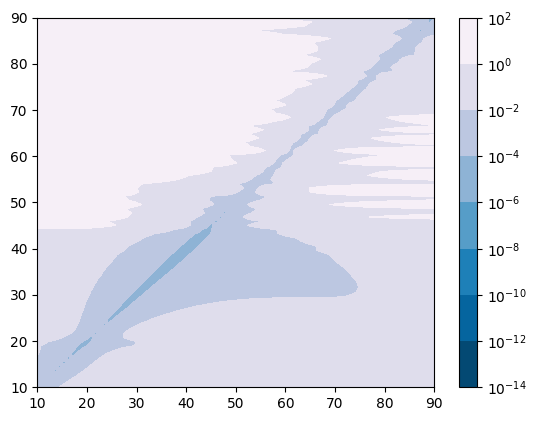

In [5]:
D = responses.gaussian(width, bw=0.2, shift=0)
MSE = SensitivityAnalysis(D, alpha0, alpha1, Nx)
plotContour_MSE(MSE, alpha0, alpha1, Nx)

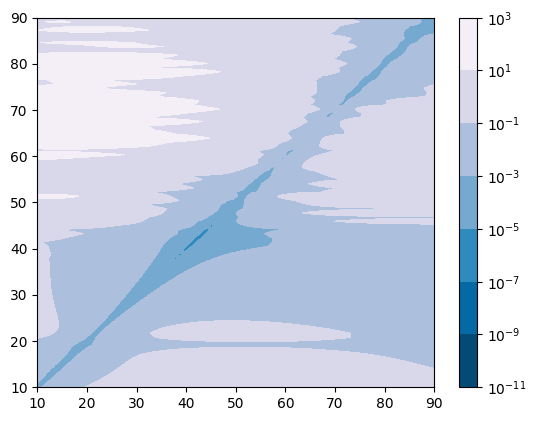

In [6]:
D = responses.gaussian(width, bw=0.2, shift=-0.25) + responses.gaussian(width, bw=0.2, shift=0.25)
MSE = SensitivityAnalysis(D, alpha0, alpha1, Nx)
plotContour_MSE(MSE, alpha0, alpha1, Nx)

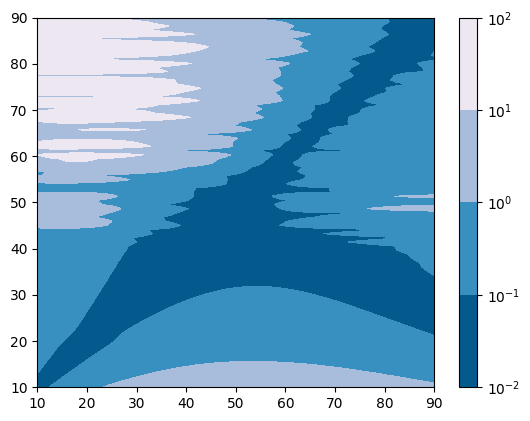

In [7]:
D = responses.notch(width, bw=0.2, shift=0)
MSE = SensitivityAnalysis(D, alpha0, alpha1, Nx)
plotContour_MSE(MSE, alpha0, alpha1, Nx)

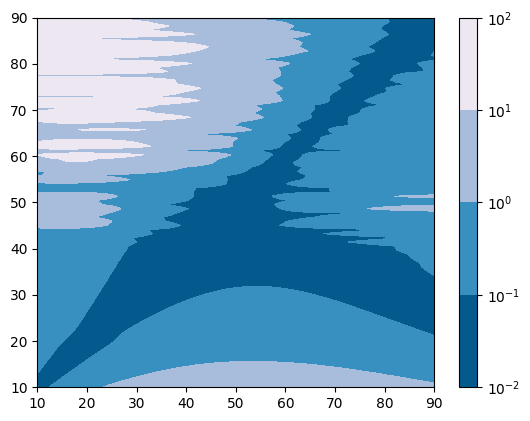

In [8]:
responses.square(width, bw=0.3, shift=0)
MSE = SensitivityAnalysis(D, alpha0, alpha1, Nx)
plotContour_MSE(MSE, alpha0, alpha1, Nx)